In [2]:
import intake
import xarray as xr
import matplotlib.pyplot as plt
import sys 
import os
from pyclim_noresm.general_util_funcs import global_avg
sys.path.append(os.path.dirname('../workflow'))
from workflow.scripts.plotting_tools import create_facet_plot,get_model_colordict, global_map
import cartopy.crs as ccrs
import matplotlib as mpl
import numpy as np
import statsmodels.api as sm

In [3]:
cat = intake.open_esm_datastore("../catalogues/merge_CMIP6.json")

In [4]:
catctrl = cat.search(
    experiment_id=['piClim-control'],
    table_id='AERmon',
    variable_id='emidust',
    source_id=['NorESM2-LM','GISS-E2-1-G','MPI-ESM-1-2-HAM',
                'MIROC6','CNRM-ESM2-1', 'UKESM1-0-LL', 'IPSL-CM6A-LR-INCA','EC-Earth3-AerChem',
                'GFDL-ESM4']
)

cat_exp = cat.search(
    experiment_id=['piClim-2xdust'],
    table_id='AERmon',
    variable_id='emidust',
    source_id=['NorESM2-LM','GISS-E2-1-G','MPI-ESM-1-2-HAM',
                'MIROC6','CNRM-ESM2-1', 'UKESM1-0-LL', 'IPSL-CM6A-LR-INCA','EC-Earth3-AerChem',
                'GFDL-ESM4']
)

In [5]:
import yaml
with open("../config/config.yaml", 'r') as f:

    conf = yaml.safe_load(f)

md_var_dict = conf['model_specific_variant']

In [6]:
def load_data(cat, model_variant_dict):
    source_ids = cat.unique()['source_id']
    out_dict = {}
    for sorceid in source_ids:
    
        temp_cat = cat
        var_lab = model_variant_dict.get(sorceid, None)
        if var_lab:
            temp_cat = temp_cat.search(member_id=var_lab)
        temp_cat = temp_cat.search(source_id=sorceid)
        temp_dict = temp_cat.to_dataset_dict()

        out_dict[sorceid] = temp_dict[list(temp_dict.keys())[0]].resample(time='Y').mean()
    return out_dict

In [7]:
def diff_ensure_same_coords(exp, ctrl):
    if np.all(exp.lon.values == ctrl.lon.values) and np.all(exp.lat.values == ctrl.lat.values):
        return exp - ctrl
    else:
        exp = exp.assign_coords(lon=ctrl.lon, lat=ctrl.lat)
        return exp - ctrl

In [8]:
def ensure_same_coords(exp, ctrl):
    if np.all(exp.lon.values == ctrl.lon.values) and np.all(exp.lat.values == ctrl.lat.values):
        return exp, ctrl
    else:
        if exp.lon.shape == ctrl.lon.shape and exp.lat.shape == ctrl.lat.shape:
            exp = exp.assign_coords(lon=ctrl.lon, lat=ctrl.lat)
            return exp, ctrl
        else:
            exp = exp.interp(lat=ctrl.lat, lon=ctrl.lon)
            return exp, ctrl

In [9]:
ctrl_dict = load_data(catctrl, md_var_dict['piClim-control'])
exp_dict = load_data(cat_exp, md_var_dict['piClim-2xdust'])


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'


In [10]:
def get_treshold(data,surfFrac=0.8):
    data_1d = data.values.ravel()
    edcf = sm.distributions.ECDF(data_1d)
    filtered = np.where(edcf.y>surfFrac, edcf.x, np.nan)
    filtered = filtered[~np.isnan(filtered)]
    return filtered.min()

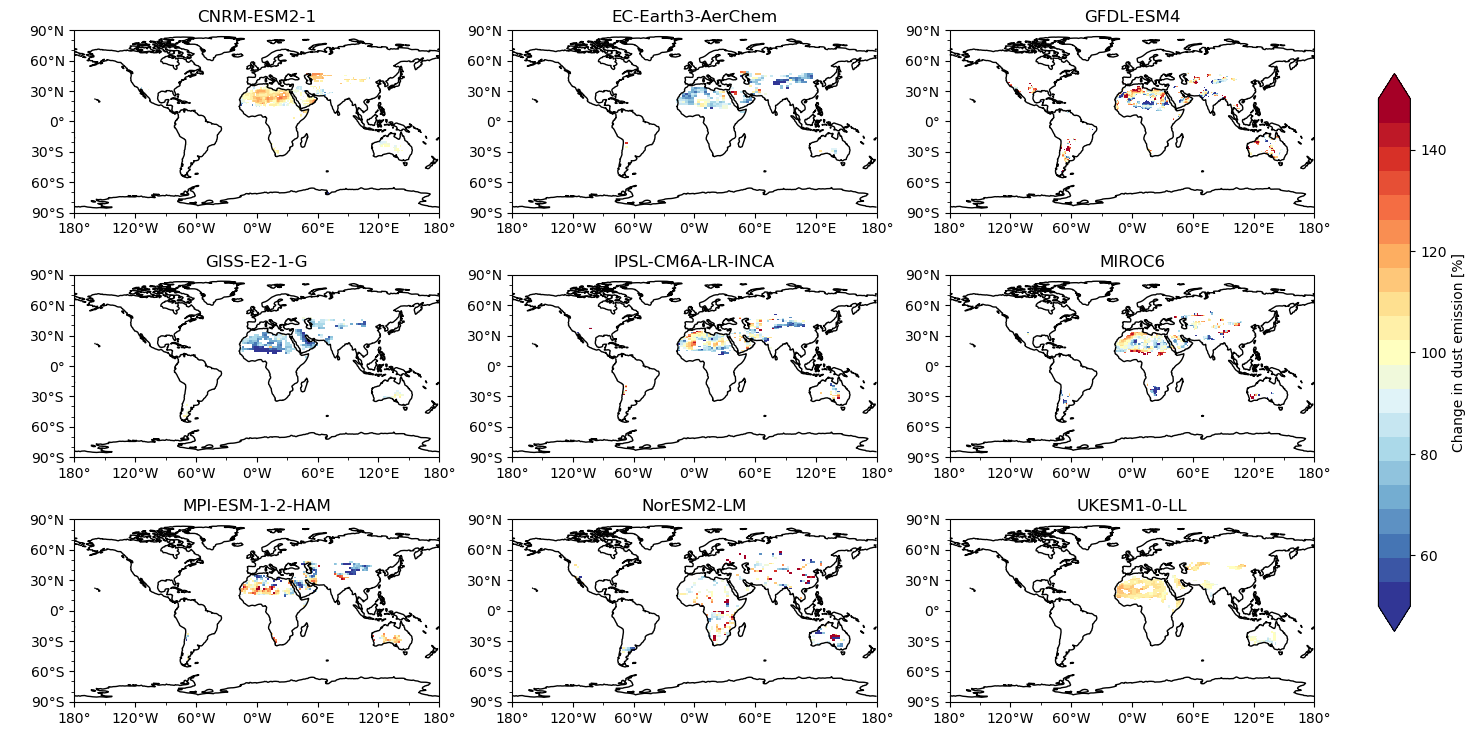

In [31]:
# fig = plt.figure(figsize=[10,16])
fig,ax, cax = create_facet_plot(9,figsize=[16,9])
cmap = mpl.colormaps.get('RdYlBu_r').resampled(21)
norm = mpl.colors.TwoSlopeNorm(vcenter=100, vmax=150, vmin=50)
diffs= {}
exp_emidust= {}

for skey, j in zip(sorted(ctrl_dict.keys()),ax):
    temp_exp = exp_dict[skey].isel(member_id=0, time=slice(2,None)).mean(dim='time')*365*24*60*60
    temp_ctrl = ctrl_dict[skey].isel(member_id=0, time=slice(2,None)).mean(dim='time')*365*24*60*60
    temp_exp, temp_ctrl = ensure_same_coords(temp_exp, temp_ctrl)
    tresh_ctrl = get_treshold(temp_ctrl['emidust'], surfFrac=0.98)
    # tresh_exp = get_treshold(temp_exp['emidust'], surfFrac=0.97)
    temp_exp = temp_exp.where(temp_exp>tresh_ctrl)
    temp_ctrl = temp_ctrl.where(temp_ctrl>tresh_ctrl)
    temp_diff = (temp_exp-temp_ctrl)/temp_ctrl
    exp_emidust[skey] = temp_exp
    diffs[skey] = temp_diff
    (temp_diff['emidust']*100).plot(ax=ax[j], cmap=cmap,add_colorbar=False, norm=norm)
    global_map(ax[j])
    ax[j].set_title(skey)
cax=fig.colorbar(mpl.cm.ScalarMappable(norm,cmap=cmap), cax=cax, extend='both')
cax.set_label('Change in dust emission [%]')
plt.savefig('dust_emission_changes.png', dpi=300, bbox_inches='tight')

In [12]:
diffs['UKESM1-0-LL'] = diffs['UKESM1-0-LL'].drop(['lat_bnds','lon_bnds'])


catctrl = cat.search(
    experiment_id=['piClim-control'],
    table_id='Amon',
    variable_id=['tauu','tauv'],
    source_id=['NorESM2-LM','GISS-E2-1-G','MPI-ESM-1-2-HAM',
                'MIROC6','CNRM-ESM2-1', 'UKESM1-0-LL', 'IPSL-CM6A-LR-INCA','EC-Earth3-AerChem',
                'GFDL-ESM4']
)

cat_exp = cat.search(
    experiment_id=['piClim-2xdust'],
    table_id='Amon',
    variable_id=['tauv','tauu'],
    source_id=['NorESM2-LM','GISS-E2-1-G','MPI-ESM-1-2-HAM',
                'MIROC6','CNRM-ESM2-1',  'IPSL-CM6A-LR-INCA','EC-Earth3-AerChem',
                'GFDL-ESM4']
)


cat_exp_uk_tauv = cat.search(
    experiment_id=['piClim-2xdust'],
    table_id='Amon',
    variable_id=['tauv'],
    source_id=['UKESM1-0-LL']
)


cat_exp_uk_tauu = cat.search(
    experiment_id=['piClim-2xdust'],
    table_id='Amon',
    variable_id=['tauu'],
    source_id=['UKESM1-0-LL']
)


cat_ctrl_uk_tauv = cat.search(
    experiment_id=['piClim-control'],
    table_id='Amon',
    variable_id=['tauv'],
    source_id=['UKESM1-0-LL']
)


cat_ctrl_uk_tauu = cat.search(
    experiment_id=['piClim-control'],
    table_id='Amon',
    variable_id=['tauu'],
    source_id=['UKESM1-0-LL']
)
tauu_exp = load_data(cat_exp_uk_tauu, md_var_dict['piClim-2xdust'])['UKESM1-0-LL']
tauv_exp = load_data(cat_exp_uk_tauv, md_var_dict['piClim-2xdust'])['UKESM1-0-LL']
tauu_exp = tauu_exp.drop(['lat_bnds','lon_bnds'])
tauv_exp = tauv_exp.drop(['lat_bnds','lon_bnds'])
tauv_exp = tauv_exp.interp(lat=tauu_exp.lat, lon=tauu_exp.lon)
stress_exp_uk = tauu_exp.merge(tauv_exp)

tauu_ctrl = load_data(cat_ctrl_uk_tauu, md_var_dict['piClim-control'])['UKESM1-0-LL']
tauv_ctrl = load_data(cat_ctrl_uk_tauv, md_var_dict['piClim-control'])['UKESM1-0-LL']
tauu_ctrl = tauu_ctrl.drop(['lat_bnds','lon_bnds'])
tauv_ctrl = tauv_ctrl.drop(['lat_bnds','lon_bnds'])
tauv_ctrl = tauv_ctrl.interp(lat=tauu_ctrl.lat, lon=tauu_ctrl.lon)
stress_ctrl_uk = tauu_ctrl.merge(tauv_ctrl)



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'


In [13]:
piclim_stress = load_data(catctrl, md_var_dict['piClim-control'])
pi2x_dust_stress = load_data(cat_exp, md_var_dict['piClim-2xdust'])


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'


In [14]:
pi2x_dust_stress['UKESM1-0-LL'] = stress_exp_uk
piclim_stress['UKESM1-0-LL'] = stress_ctrl_uk

In [15]:
def calculate_stress(data):
    stress = np.sqrt(data['tauv']**2+data['tauu']**2)
    return stress

exp_stress = {k: calculate_stress(pi2x_dust_stress[k]).isel(member_id=0, time=slice(1,None)).mean(dim='time') for k in pi2x_dust_stress}

In [16]:
ctrl_stress = {k: calculate_stress(piclim_stress[k]).isel(member_id=0).mean(dim='time') for k in piclim_stress}

In [17]:
diff_stress = {k: diff_ensure_same_coords(exp_stress[k],ctrl_stress[k]) for k in exp_stress}

In [18]:
def calc_density(data):
    ps, tas = ensure_same_coords(data['ps'], data['tas'])
    return ps/(287.058*tas)

In [19]:

density_ctrl = cat.search(
    experiment_id=['piClim-control'],
    table_id='Amon',
    variable_id=['tas','ps'],
    source_id=['NorESM2-LM','GISS-E2-1-G','MPI-ESM-1-2-HAM',
                'MIROC6','CNRM-ESM2-1', 'UKESM1-0-LL', 'IPSL-CM6A-LR-INCA',
                'GFDL-ESM4']
)

density_exp = cat.search(
    experiment_id=['piClim-2xdust'],
    table_id='Amon',
    variable_id=['tas','ps'],
    source_id=['NorESM2-LM','GISS-E2-1-G','MPI-ESM-1-2-HAM',
                'MIROC6','CNRM-ESM2-1', 'UKESM1-0-LL', 'IPSL-CM6A-LR-INCA',
                'GFDL-ESM4']
)



ec_density_ctrl = cat.search(
    experiment_id=['piClim-control'],
    table_id='Amon',
    variable_id=['tas'],
    source_id=['EC-Earth3-AerChem']
).to_dataset_dict()['RFMIP.EC-Earth-Consortium']

ec_density_exp = cat.search(
    experiment_id=['piClim-2xdust'],
    table_id='Amon',
    variable_id=['tas'],
    source_id=['EC-Earth3-AerChem']
).to_dataset_dict()['AerChemMIP.EC-Earth-Consortium']


ec_ps_ctrl = cat.search(
    experiment_id=['piClim-control'],
    table_id='CFmon',
    variable_id=['ta'],
    source_id=['EC-Earth3-AerChem']
).to_dataset_dict()['RFMIP.EC-Earth-Consortium'][['ps']]

ec_ps_exp = cat.search(
    experiment_id=['piClim-2xdust'],
    table_id='CFmon',
    variable_id=['ta'],
    source_id=['EC-Earth3-AerChem']
).to_dataset_dict()['AerChemMIP.EC-Earth-Consortium'][['ps']]


ps_ec_ctrl = ec_ps_ctrl['ps'].resample(time='Y').mean()
ec_density_ctrl = ec_density_ctrl.resample(time='Y').mean()
ps_ec_exp = ec_ps_exp['ps'].resample(time='Y').mean()
ec_density_exp = ec_density_exp.resample(time='Y').mean()
ec_density_ctrl = ec_density_ctrl.assign(ps=ps_ec_ctrl)
ec_density_exp = ec_density_exp.assign(ps=ps_ec_exp)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'


In [20]:
data_density_exp = load_data(density_exp, md_var_dict['piClim-2xdust'])
data_density_ctrl = load_data(density_ctrl, md_var_dict['piClim-control'])



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'


In [21]:
data_density_ctrl['EC-Earth3-AerChem'] = ec_density_ctrl
data_density_exp['EC-Earth3-AerChem'] = ec_density_exp
density_exp = {k: calc_density(data_density_exp[k]) for k in data_density_exp}
density_ctrl = {k: calc_density(data_density_ctrl[k]) for k in data_density_ctrl}

In [22]:
def calculate_friction_velocity(tau, density):
    tau, density =ensure_same_coords(tau, density)
    return np.sqrt(tau/density)

In [23]:
fric_vel_exp = {k: calculate_friction_velocity(exp_stress[k], density_exp[k]).isel(time=slice(1,None), member_id=0).mean(dim='time') for k in density_exp}
fric_vel_ctrl = {k: calculate_friction_velocity(ctrl_stress[k], density_ctrl[k]).isel(member_id=0).mean(dim='time') for k in density_ctrl}
diff_fric_vel = {k: diff_ensure_same_coords(fric_vel_exp[k],fric_vel_ctrl[k]) for k in fric_vel_exp}

In [24]:
def dttau_demis(dstress, ctrl_emis, ddust_emis):
    # if np.all(dstress.lon == ctrl_emis.lon) and np.all(dstress.lat == ctrl_emis.lat):
    dstress, ctrl_emis = ensure_same_coords(dstress, ctrl_emis)
    ctrl_emis, ddust_emis = ensure_same_coords(ctrl_emis, ddust_emis)
    return dstress*(ddust_emis/(2*ctrl_emis))

In [25]:
def ttau_emis_dttau(dstress, dd_stress, ddust_emis):
    # if np.all(dstress.lon == ctrl_emis.lon) and np.all(dstress.lat == ctrl_emis.lat):
    dstress, ddust_emis = ensure_same_coords(dstress,ddust_emis,)
    dd_stress, ddust_emis = ensure_same_coords(dd_stress,ddust_emis)
    # dd_stress, ddust_emis = ensure_same_coords(dd_stress, ddust_emis)
    return (ddust_emis/dd_stress)*dstress

In [26]:
exp_dict

{'CNRM-ESM2-1': <xarray.Dataset>
 Dimensions:    (lat: 128, lon: 256, time: 30, member_id: 1)
 Coordinates:
   * lat        (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
   * lon        (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
   * member_id  (member_id) object 'r1i1p1f2'
   * time       (time) datetime64[ns] 1850-12-31 1851-12-31 ... 1879-12-31
 Data variables:
     emidust    (time, member_id, lat, lon) float32 dask.array<chunksize=(1, 1, 128, 256), meta=np.ndarray>
 Attributes: (12/66)
     Conventions:                      CF-1.7 CMIP-6.2
     creation_date:                    2018-07-31T13:54:16Z
     description:                      1850 control with doubled dust emissions
     title:                            CNRM-ESM2-1 model output prepared for C...
     activity_id:                      AerChemMIP
     contact:                          contact.cmip@meteo.fr
     ...                               ...
     intake_esm_attrs:activity_id:

In [27]:
dttau_demis_dict = {k: ttau_emis_dttau(diff_fric_vel[k], fric_vel_exp[k], exp_emidust[k]['emidust']) for k in diff_stress}

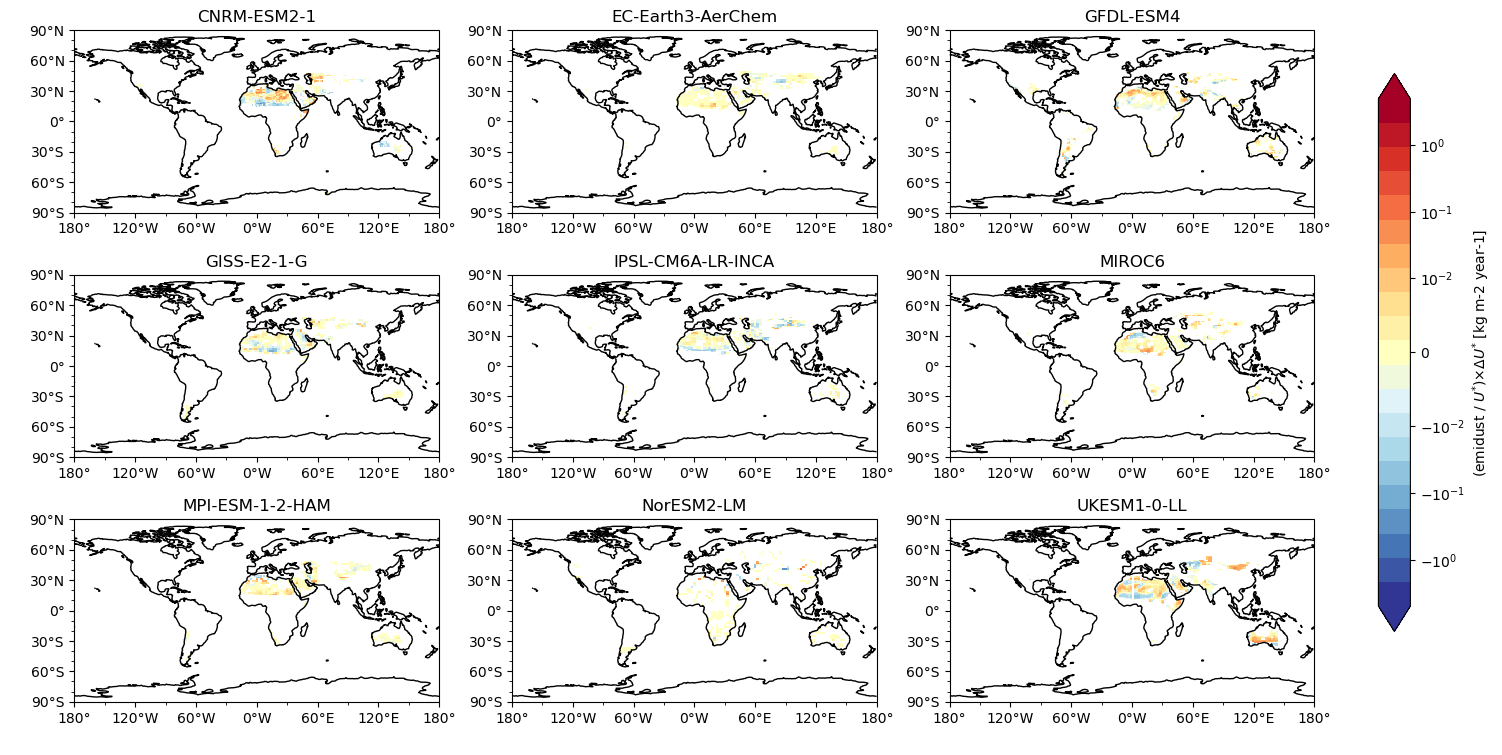

In [33]:

# fig = plt.figure(figsize=[10,16])
# dttau_demis_dict.pop('EC-Earth3-AerChem')
fig,ax, cax = create_facet_plot(9,figsize=[16,9])
cmap = mpl.colormaps.get('RdYlBu_r').resampled(21)
norm = mpl.colors.SymLogNorm(vmax=5e0, vmin=-5e0, linthresh=1e-2, linscale=1)

for skey, j in zip(sorted(dttau_demis_dict.keys()),ax):

    dttau_demis_dict[skey].plot(ax=ax[j],norm=norm, cmap=cmap,add_colorbar=False)
    global_map(ax[j])
    ax[j].set_title(skey)
cax=fig.colorbar(mpl.cm.ScalarMappable(norm,cmap=cmap), cax=cax, extend='both')
cax.set_label(r'(emidust / $ U^{*} $)$\times \Delta U^{*} $ [kg m-2 year-1]' )
plt.savefig('../emission_change_per_changes.png', dpi=300, bbox_inches='tight')

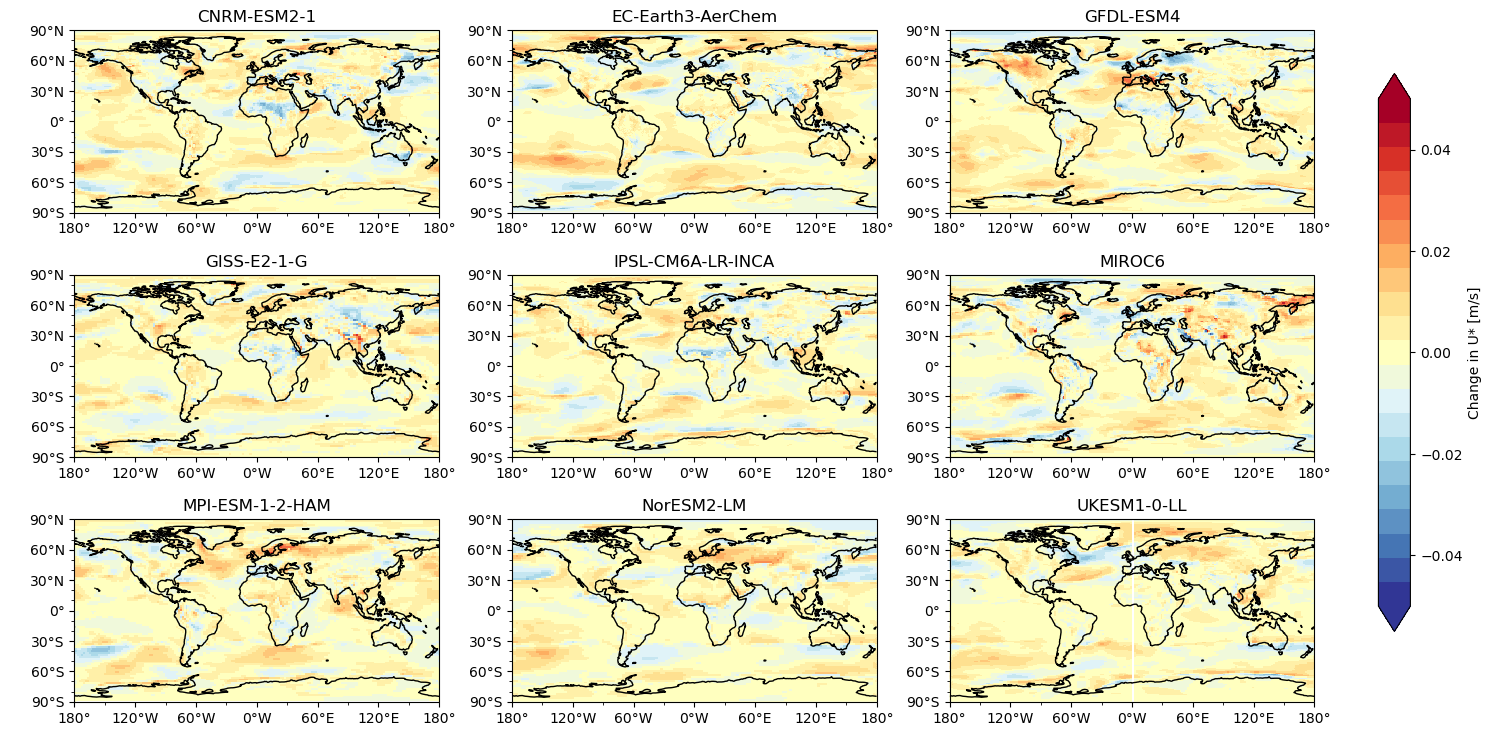

In [29]:
# fig = plt.figure(figsize=[10,16])
fig,ax, cax = create_facet_plot(9,figsize=[16,9])
cmap = mpl.colormaps.get('RdYlBu_r').resampled(21)
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=0.05, vmin=-0.05 )

for skey, j in zip(sorted(diff_fric_vel.keys()),ax):

    diff_fric_vel[skey].plot(ax=ax[j], cmap=cmap,add_colorbar=False, norm=norm)
    global_map(ax[j])
    ax[j].set_title(skey)
cax=fig.colorbar(mpl.cm.ScalarMappable(norm,cmap=cmap), cax=cax, extend='both')
cax.set_label('Change in U* [m/s]')
plt.savefig('friction_velocity_changes.png', dpi=300, bbox_inches='tight')